In [31]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point

In [32]:
airbnb = pd.read_csv("data/20240614-London-listings.csv.gz")

airbnb = gpd.GeoDataFrame(airbnb, 
                       geometry=gpd.points_from_xy(airbnb.longitude, airbnb.latitude), 
                       crs="EPSG:4326").to_crs(epsg=27700)

In [38]:
ward_profiles = pd.read_csv("data/ward-profiles.csv", encoding="latin1")

ward_profiles.head(5)

,Ward name,Old code,New code,Population - 2015,Children aged 0-15 - 2015,Working-age (16-64) - 2015,Older people aged 65+ - 2015,% All Children aged 0-15 - 2015,% All Working-age (16-64) - 2015,% All Older people aged 65+ - 2015,...,A-Level Average Point Score Per Student - 2013/14,A-Level Average Point Score Per Entry; 2013/14,Crime rate - 2014/15,Violence against the person rate - 2014/15,"Deliberate Fires per 1,000 population - 2014",% area that is open space - 2014,Cars per household - 2011,Average Public Transport Accessibility score - 2014,% travel by bicycle to work - 2011,Turnout at Mayoral election - 2012
0,City of London,00AA,E09000001,8100,650,6250,1250,8.0,76.9,15.2,...,662.9,210.5,656.4,85.3,0.4,18.6,0.4,7.9,5.3,48.5
1,Barking and Dagenham - Abbey,00ABFX,E05000026,14750,3850,10150,750,26.0,69.0,5.0,...,682.6,208.9,138.1,42.2,1.4,21.9,0.5,6.0,0.8,25.7
2,Barking and Dagenham - Alibon,00ABFY,E05000027,10600,2700,6800,1050,25.7,64.3,10.0,...,627.9,201.6,73.6,27.3,0.7,20.6,0.8,3.1,1.0,20.3
3,Barking and Dagenham - Becontree,00ABFZ,E05000028,12700,3200,8350,1100,25.4,65.9,8.7,...,632.0,207.9,79.9,27.6,1.2,1.9,0.9,2.9,1.6,22.5
4,Barking and Dagenham - Chadwell Heath,00ABGA,E05000029,10400,2550,6400,1450,24.3,61.5,14.2,...,613.9,210.5,76.1,24.6,1.3,56.0,0.9,2.3,1.2,25.3


In [35]:
wards = gpd.read_file("data/London-wards-2014/London-wards-2014_ESRI/London_Ward.shp").to_crs(epsg=27700)[["GSS_CODE","HECTARES","geometry"]]

wards.head(5)

,GSS_CODE,HECTARES,geometry
0,E05000405,755.173,"POLYGON ((516401.6 160201.8, 516407.3 160210.5..."
1,E05000414,259.464,"POLYGON ((517829.6 165447.1, 517837.1 165469.4..."
2,E05000401,145.390,"POLYGON ((518107.5 167303.4, 518114.3 167307.5..."
3,E05000400,268.506,"POLYGON ((520480 166909.8, 520490.7 166901.9, ..."
4,E05000402,187.821,"POLYGON ((522071 168144.9, 522063.9 168144, 52..."


In [36]:
travel = pd.read_csv("data/Ward2014PTAI.csv")

travel.head(5)

,Ward Code,Ward Name,AvPTAI2015,PTAL
0,E05000405,Chessington South,1.743083,1a
1,E05000414,Tolworth and Hook Rise,3.644788,1b
2,E05000401,Berrylands,5.655172,2
3,E05000400,Alexandra,3.933086,1b
4,E05000402,Beverley,7.062827,2


In [37]:
pubs = gpd.read_file("data/pubs.geojson").to_crs(epsg=27700)
pubs["geometry"] = pubs.geometry.centroid

pubs = pubs[["name","geometry"]]

pubs.head(5)

,name,geometry
0,The Queens,POINT (530228.555 188568.967)
1,The Gilpin's Bell,POINT (534047.067 191909.103)
2,The Ship and Shovell,POINT (530236.721 180413.513)
3,Crown and Sceptre,POINT (522498.283 179750.168)
4,Princess Victoria,POINT (522169.523 180067.4)


## merging

In [41]:
merged = wards.merge(travel, left_on = "GSS_CODE", right_on = "Ward Code", how = "left")

merged = merged.merge(ward_profiles, left_on = "GSS_CODE", right_on = "New code", how = "left")

merged = gpd.GeoDataFrame(merged, crs = "EPSG:27700")

merged.head(5)

,GSS_CODE,HECTARES,geometry,Ward Code,Ward Name,AvPTAI2015,PTAL,Ward name,Old code,New code,...,A-Level Average Point Score Per Student - 2013/14,A-Level Average Point Score Per Entry; 2013/14,Crime rate - 2014/15,Violence against the person rate - 2014/15,"Deliberate Fires per 1,000 population - 2014",% area that is open space - 2014,Cars per household - 2011,Average Public Transport Accessibility score - 2014,% travel by bicycle to work - 2011,Turnout at Mayoral election - 2012
0,E05000405,755.173,"POLYGON ((516401.6 160201.8, 516407.3 160210.5...",E05000405,Chessington South,1.743083,1a,Kingston upon Thames - Chessington South,00AXGC,E05000405,...,643.4,203.6,47.5,16.3,0.6,75.7,1.4,2.4,2.3,30.4
1,E05000414,259.464,"POLYGON ((517829.6 165447.1, 517837.1 165469.4...",E05000414,Tolworth and Hook Rise,3.644788,1b,Kingston upon Thames - Tolworth and Hook Rise,00AXGM,E05000414,...,714.3,213.3,53.7,14.2,0.7,33.1,1.2,2.3,2.9,32.1
2,E05000401,145.390,"POLYGON ((518107.5 167303.4, 518114.3 167307.5...",E05000401,Berrylands,5.655172,2,Kingston upon Thames - Berrylands,00AXFY,E05000401,...,733.7,212.9,31.6,8.2,0.3,10.9,1.0,2.8,4.6,38.0
3,E05000400,268.506,"POLYGON ((520480 166909.8, 520490.7 166901.9, ...",E05000400,Alexandra,3.933086,1b,Kingston upon Thames - Alexandra,00AXFX,E05000400,...,762.2,215.2,34.7,7.9,0.3,43.7,1.4,2.2,3.9,36.3
4,E05000402,187.821,"POLYGON ((522071 168144.9, 522063.9 168144, 52...",E05000402,Beverley,7.062827,2,Kingston upon Thames - Beverley,00AXFZ,E05000402,...,761.5,219.3,64.5,15.4,0.7,26.4,1.0,2.8,4.4,41.2


In [20]:
merged["n_pubs"] = merged.geometry.apply(lambda geom: sum(pubs.geometry.intersects(geom)))
merged["pub_density"] = merged["n_pubs"] / merged["HECTARES"]

merged["n_airbnb"] = merged.geometry.apply(lambda geom: sum(airbnb.geometry.intersects(geom)))
merged["airbnb_density"] = merged["n_airbnb"] / merged["HECTARES"]


<Axes: >

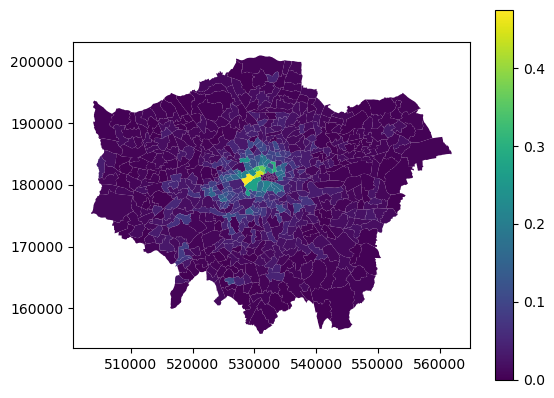

In [28]:
merged.plot(column = "pub_density", cmap="viridis", legend = True)

In [29]:
merged.sort_values(by='pub_density', ascending=False).head(25)

,GSS_CODE,HECTARES,geometry,Ward Code,Ward Name,AvPTAI2015,PTAL,n_pubs,pub_density,n_airbnb,airbnb_density
484,E05000649,199.973,"POLYGON ((528386.7 179725.6, 528381.1 179730.1...",E05000649,West End,65.030303,6b,95,0.475064,1369,6.845924
502,E05000138,119.493,"POLYGON ((529928.5 181049, 529927.7 181049.5, ...",E05000138,Holborn and Covent Garden,63.050420,6b,53,0.443541,796,6.661478
536,E05000370,93.263,"POLYGON ((530510 183011.6, 530546.8 183018.6, ...",E05000370,Clerkenwell,37.677083,6a,34,0.364560,427,4.578450
506,E05000141,61.138,"POLYGON ((530326.1 182983.3, 530364.8 182991.4...",E05000141,King's Cross,65.728814,6b,20,0.327129,520,8.505349
552,E05009377,102.355,"POLYGON ((532942.7 182547.9, 532938.5 182560.8...",E05009377,Hoxton East & Shoreditch,38.504854,6a,31,0.302867,668,6.526306
478,E05000644,346.379,"POLYGON ((530410.6 178958.5, 530281.3 178974.1...",E05000644,St. James's,66.445087,6b,95,0.274266,1141,3.294080
492,E05000647,57.354,"POLYGON ((529030 179150.4, 529063.7 179046.1, ...",E05000647,Warwick,64.736842,6b,15,0.261534,399,6.956795
504,E05000130,116.615,"POLYGON ((528214 183685.5, 528166.7 183678.9, ...",E05000130,Camden Town with Primrose Hill,25.092437,6a,28,0.240106,423,3.627321
501,E05000129,102.091,"POLYGON ((528891.1 182192.6, 528900.9 182190.5...",E05000129,Bloomsbury,65.543689,6b,24,0.235084,584,5.720387
543,E05000367,108.263,"POLYGON ((532083.4 181950, 532081.1 181915.5, ...",E05000367,Bunhill,44.000000,6b,24,0.221682,523,4.830829
